# Instructions for Project 1 - Sentiment Classification

Hello everyone, this is Zihao. I am very happy to host the first project

In this project, you will conduct a sentiment analysis task.
You will build a model to predict the scores (a.k.a. stars, from 1-5) of each review.
For each review, you are given a piece of text as well as some other features (Explore yourself!).
You can consider the predicted variables to be categorical, ordinal or numerical.

DDL: *April 6, 2021*
- *March 23, 2021* release the validation score of weak baseline
- *March 30, 2021* release the validation score of strong baseline

Submission: Each team leader is required to submit the groupNo.zip file in the canvas. It shoud contain 
- `pre.csv` Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py)
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted.)

We will check your report with your code and the accuracy.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | example code in tutorials or in Project 1 without any modification | submission                        |
| 60%   | an easy baseline that most students can outperform                 | algorithm you used                |
| 80%   | a competitive baseline that about half students can surpass        | detailed explanation              |
| 90%   | a very competitive baseline without any special mechanism          | detailed explanation and analysis, such as explorative data analysis and ablation study |
| 100%  | a very competitive baseline with at least one mechanism            | excellent ideas, detailed explanation and solid analysis |



In this notebook, you are provided with the code snippets for you to start.

The content follows previous lectures and tutorials. But I may mention some useful python packages.

## Instruction Content

1. Load & Dump the data
    1. Load the data
    1. Dump the data
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

## 1. Load & Dump the data

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [1]:
import pandas as pd

### A. Load the data

Here is a function to load your data, remember put the dataset in the `data_2021_spring` folder.

Each year we release different data, so old models are not guaranteed to solve the new data.

In [2]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

Then you can extract the data by specifying the desired split and columns

In [3]:
train_df = load_data('train', columns=['text'])

select [text] columns from the train split
succeed!


In [4]:
train_df.head()

text
0  Nice to have a diner still around. Food was go...
1  Tried this a while back, got the fried chicken...
2  I expected more pork selections on menu. Food ...
3  YUMMY!!! This place is phenomenal. It is Price...
4  The Truffle Macaroni & Cheese and Potatoes Au ...

In [5]:
test_df = load_data('test')

select [text, stars] columns from the test split
Failed, then try to 
select all columns from the test split


In [6]:
len(test_df)

2000

### B. Dump the random answer

In this project, your predictions on test data are supposed to be submitted by a csv file of two columns, i.e. (review_id and stars)

Here we compose the random answer in a DataFrame and dump the answer into a csv file

In [7]:
import numpy as np

In [8]:
random_ans = pd.DataFrame(data={
    'review_id': test_df['review_id'],
    'stars': np.random.randint(0, 6, size=len(test_df))
})

In [9]:
random_ans.head()

review_id  stars
0  b8-ELBwhmDKcmcM8icT86g      2
1  rBpAJhIen_V-zLoXZIcROg      0
2  _pALaDG6se9OTkGGhyhnNA      0
3  ru8fpA1Uk0tTFtO5hLM49g      2
4  fRPgwuFoY6SriToXZyaOQA      0

In [10]:
group_number = -1
random_ans.to_csv(f'{group_number}-random_ans.csv', index=False)

## 2. Preprocessing

Preprocessing and feature engineering is important in machine learning

### A. Text data processing recap
In our tutorials, Haoran have showed you how to extract textual features by the `nltk` package

Remember to use the NLTK Downloader to obtain the resource:
```
  >>> import nltk
  >>> nltk.download('stopwords')
  >>> nltk.download('punkt')
```

In [11]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

Note that you can use the `map` function to apply your preprocessing functions into the dataframe.

In [12]:
test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)
print(test_df['tokens'].head().to_string())

0    [i, took, up, train, union, station, catch, ai...
1    [we, worked, fitness, twist, part, best, frien...
2    [it, 's, typical, ,, average, ,, run-of-the-mi...
3    [we, went, outback, today, celebrate, daughter...
4    [we, went, see, nashville, unplugged, country,...


Besides `nltk`, I would like to introduce `SpaCy`, a newer text processing toolkit of industrial strength.

You can explore it at https://spacy.io/

Let's install it

```bash
python -m pip install spacy
python -m spacy download en_core_web_sm
```

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

SpaCy enables you use linguistic features of texts

Example:

In [14]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

fmt = "{:10s},\t " * 8
print(fmt.format('raw', 'stem', 'PartOfSpeech', 'dependency', 'shape', 'is alpha', 'is stop', 'its childrens in the parsing tree'))
print('-'*140)
for token in doc:
    print(fmt.format(token.text, token.lemma_, token.pos_, token.dep_,
            token.shape_, str(token.is_alpha), str(token.is_stop), str(list(token.children))))

raw       ,	 stem      ,	 PartOfSpeech,	 dependency,	 shape     ,	 is alpha  ,	 is stop   ,	 its childrens in the parsing tree,	 
--------------------------------------------------------------------------------------------------------------------------------------------
Apple     ,	 Apple     ,	 PROPN     ,	 nsubj     ,	 Xxxxx     ,	 True      ,	 False     ,	 []        ,	 
is        ,	 be        ,	 AUX       ,	 aux       ,	 xx        ,	 True      ,	 True      ,	 []        ,	 
looking   ,	 look      ,	 VERB      ,	 ROOT      ,	 xxxx      ,	 True      ,	 False     ,	 [Apple, is, at, startup],	 
at        ,	 at        ,	 ADP       ,	 prep      ,	 xx        ,	 True      ,	 True      ,	 [buying]  ,	 
buying    ,	 buy       ,	 VERB      ,	 pcomp     ,	 xxxx      ,	 True      ,	 False     ,	 [U.K.]    ,	 
U.K.      ,	 U.K.      ,	 PROPN     ,	 dobj      ,	 X.X.      ,	 False     ,	 False     ,	 []        ,	 
startup   ,	 startup   ,	 NOUN      ,	 advcl     ,	 xxxx      ,	 True      ,	 False  

SpaCy also allows you use the embeddings for both sentence and words

Example:

In [15]:
print(doc, doc.vector[:5], '...')
for t in doc:
    print(t, t.vector[:5], '...')

Apple is looking at buying U.K. startup for $1 billion [ 0.4847193   0.34561655  0.23650904 -0.27294627  0.30828613] ...
Apple [ 0.9396687   0.46727175 -0.3862503  -0.23296848  0.25683203] ...
is [-0.21470308 -0.36800703  1.8618155  -0.43874717 -0.6448474 ] ...
looking [ 1.5960355  -0.01218066 -0.1948367   0.7979922   0.36900565] ...
at [-1.2617028  -0.8116296  -0.55736023  0.08604071 -0.43663728] ...
buying [ 0.3020423  -0.9611639   1.2695026   0.10633498  2.8583994 ] ...
U.K. [ 2.2959712   0.78135234 -1.0174923  -0.5566485   0.69199914] ...
startup [0.6782811  0.03798376 0.07798427 0.1210558  0.5636424 ] ...
for [-0.07904667 -0.21996386 -1.3529027  -0.24131706  0.43687835] ...
$ [ 0.44878927  0.75564337  0.5757578  -1.1713823   0.7438692 ] ...
1 [-0.3846085  2.7049747  2.7081459 -1.4393395 -0.5412608] ...
billion [ 1.011186    1.4275012  -0.38276425 -0.03342953 -0.9067332 ] ...


For more usage of SpaCy, you can refer to the documentation of spacy https://spacy.io/usage

### B. Explorative data analysis

For our dataset, we have features more than text

In [16]:
train_df_full = load_data('train', columns='full')

select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split


In [17]:
train_df_full.head()

business_id  cool                 date  funny  \
0  39rLHYJOy2774ZIUouuWLw     0  2017-06-28 21:44:02      0   
1  E-Kq1Yu1d6N3TL2qX0aqjA     0  2018-04-09 03:45:19      0   
2  nWW6fBfBljiRFa4sG7TyxA     0  2014-07-19 02:00:04      0   
3  qmIHO-6T_KEfPC9jyGDamQ     0  2011-11-11 08:10:24      0   
4  pKk7jCFIm96qDdk0laVT2w     1  2010-01-16 20:04:00      1   

                review_id  stars  \
0  ynzOFepQYSCDGdfWDWxiZw      4   
1  sQX9ncJBEdBf16AWsvO6Vg      2   
2  bVIf2kqbzvif3miNe3ARNw      4   
3  LNj1OFxy2ool3PZANGchPA      4   
4  bZXxa0hO6wQlHD-MkMf4iw      5   

                                                text  useful  \
0  Nice to have a diner still around. Food was go...       0   
1  Tried this a while back, got the fried chicken...       0   
2  I expected more pork selections on menu. Food ...       0   
3  YUMMY!!! This place is phenomenal. It is Price...       0   
4  The Truffle Macaroni & Cheese and Potatoes Au ...       1   

                  user_id  
0  Sl6VgFOB-XXfFIAYp7TFkw  
1  gcx01pMqWzkni2UC-zoZrA  
2  Mn9VzPbrCYU4EcP_C1oBOg  
3  SKV1heo00fdciCbCN9Z33A  
4  p1r7rZYruZR92x1A649PTQ

You can explore the relationship between different features

In [18]:
import matplotlib.pyplot as plt

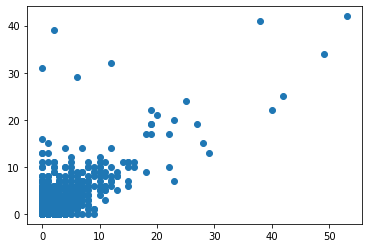

In [19]:
plt.scatter(train_df_full['cool'], train_df_full['funny'])

(array([2534., 1354., 1888., 2110., 2114.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

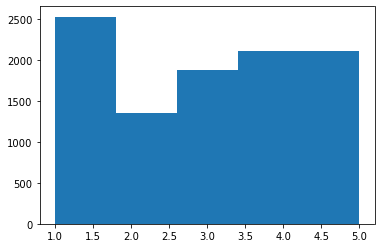

In [20]:
plt.hist(train_df_full['stars'], bins=5)

Moreover, you may use the id feature to aggregate data samples

For example

                 business_id  funny  cool  stars
7043  -0qht1roIqleKiQkBLDkbw      1     0      3
7363  -0qht1roIqleKiQkBLDkbw      0     0      5


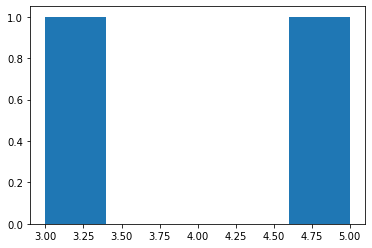

In [21]:
for bid, sub_df in train_df_full.groupby('business_id'):
    if len(sub_df) > 1:
        print(sub_df[['business_id', 'funny', 'cool', 'stars']].head())
        plt.hist(sub_df['stars'], bins=5)
        break

In [22]:
for bid, sub_df in train_df_full.groupby('user_id'):
    if len(sub_df) > 1:
        print(sub_df[['user_id', 'funny', 'cool', 'stars']].head())
        break

                     user_id  funny  cool  stars
1173  -SjQXQd-IRfOdUdYYwWGOQ      0     1      4
4503  -SjQXQd-IRfOdUdYYwWGOQ      0     0      1


## 3. Baselines

Finally, we come up with two baselines for you to refer.
We only use text data here and only consider first 5k training samples.

For example, a baseline can be a logistic regression

In [23]:
train_df = load_data('train')[:5000]
valid_df = load_data('valid')

select [text, stars] columns from the train split
succeed!
select [text, stars] columns from the valid split
succeed!


The split above is what we have done for you. You can use the data as you like.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [25]:
x_train = train_df['text']
y_train = train_df['stars']

In [26]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
lr = LogisticRegression()
steps = [('tfidf', tfidf),('lr', lr)]
pipe = Pipeline(steps)
print(pipe)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fa08c9590d0>)),
                ('lr', LogisticRegression())])


In [27]:
pipe.fit(x_train, y_train)

/Users/bytedance/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fa08c9590d0>)),
                ('lr', LogisticRegression())])

In [28]:
x_valid = valid_df['text']
y_valid = valid_df['stars']
y_pred = pipe.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.66      0.88      0.75       517
           2       0.41      0.14      0.21       278
           3       0.44      0.47      0.45       344
           4       0.50      0.51      0.50       427
           5       0.70      0.67      0.68       434

    accuracy                           0.58      2000
   macro avg       0.54      0.53      0.52      2000
weighted avg       0.56      0.58      0.56      2000




[[456  23  21  11   6]
 [119  38  96  20   5]
 [ 64  22 160  87  11]
 [ 22   6  78 217 104]
 [ 32   3  11  99 289]]
accuracy 0.58


Of course, you can use deep learning.
Here is a pytorch based baseline using CNN

```bash
pip install torch
```

In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

In [30]:
train_text = train_df['text'].map(tokenize).map(filter_stopwords).map(stem)
valid_text = valid_df['text'].map(tokenize).map(filter_stopwords).map(stem)

In [31]:
word2id = {}
for tokens in train_text:
    for t in tokens:
        if not t in word2id:
            word2id[t] = len(word2id)
word2id['<pad>'] = len(word2id)

In [32]:
def texts_to_id_seq(texts, padding_length=500):
    records = []
    for tokens in texts:
        record = []
        for t in tokens:
            record.append(word2id.get(t, len(word2id)))
        if len(record) >= padding_length:
            records.append(record[:padding_length])
        else:
            records.append(record + [word2id['<pad>']] * (padding_length - len(record)))
    return records

In [33]:
train_seqs = texts_to_id_seq(train_text)

In [34]:
valid_seqs = texts_to_id_seq(valid_text)

In [35]:
class MyDataset(Dataset):
    
    def __init__(self, seq, y):
        assert len(seq) == len(y)
        self.seq = seq
        self.y = y-1
    
    def __getitem__(self, idx):
        return np.asarray(self.seq[idx]), self.y[idx]

    def __len__(self):
        return len(self.seq)

In [36]:
batch_size = 16

train_loader = DataLoader(MyDataset(train_seqs, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(MyDataset(valid_seqs, y_valid), batch_size=batch_size)

In [37]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(word2id)+1, embedding_dim=64)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.embedding(x)
        x = torch.transpose(x, 1, 2)
        x = self.cnn(x)
        x = torch.max(x, dim=-1)[0]
        x = self.linear(x)
        return x

In [38]:
model = mlp()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [39]:
for e in range(1, 11):    
    print('epoch', e)
    model.train()
    total_acc = 0
    total_loss = 0
    total_count = 0
    with tqdm.tqdm(train_loader) as t:
        for x, y in t:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += y.size(0)
            total_loss += loss.item()
            optimizer.step()
            t.set_postfix({'loss': total_loss/total_count, 'acc': total_acc/total_count})

    model.eval()
    y_pred = []
    y_true = []
    with tqdm.tqdm(valid_loader) as t:
        for x, y in t:
            logits = model(x)
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += len(y)
            y_pred += logits.argmax(1).tolist()
            y_true += y.tolist()
    print(classification_report(y_true, y_pred))
    print("\n\n")
    print(confusion_matrix(y_true, y_pred))

  1%|          | 2/313 [00:00<00:22, 14.09it/s, loss=0.104, acc=0.219]

epoch 1


  1%|          | 2/313 [00:00<00:18, 17.18it/s, loss=0.0935, acc=0.333]

              precision    recall  f1-score   support

           0       0.35      0.90      0.51       517
           1       0.14      0.01      0.02       278
           2       0.24      0.01      0.02       344
           3       0.39      0.20      0.26       427
           4       0.47      0.47      0.47       434

    accuracy                           0.38      2000
   macro avg       0.32      0.32      0.26      2000
weighted avg       0.34      0.38      0.30      2000




[[464   3   1  10  39]
 [221   3   5  25  24]
 [245   7   4  47  41]
 [207   4   7  84 125]
 [172   4   0  52 206]]
epoch 2


  1%|          | 2/313 [00:00<00:18, 16.59it/s, loss=0.0668, acc=0.562]

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       517
           1       0.32      0.12      0.18       278
           2       0.32      0.38      0.35       344
           3       0.41      0.39      0.40       427
           4       0.53      0.62      0.57       434

    accuracy                           0.48      2000
   macro avg       0.44      0.44      0.43      2000
weighted avg       0.46      0.48      0.46      2000




[[358  28  58  20  53]
 [ 92  34  90  34  28]
 [ 54  26 131  98  35]
 [ 28  11 100 166 122]
 [ 44   6  28  88 268]]
epoch 3


  1%|          | 2/313 [00:00<00:18, 16.67it/s, loss=0.0541, acc=0.708]

              precision    recall  f1-score   support

           0       0.72      0.59      0.65       517
           1       0.29      0.38      0.33       278
           2       0.38      0.12      0.18       344
           3       0.39      0.50      0.44       427
           4       0.52      0.66      0.58       434

    accuracy                           0.48      2000
   macro avg       0.46      0.45      0.44      2000
weighted avg       0.49      0.48      0.46      2000




[[304 111  10  37  55]
 [ 60 107  26  52  33]
 [ 29 101  40 137  37]
 [ 12  38  24 214 139]
 [ 17  13   6 110 288]]
epoch 4


  1%|          | 2/313 [00:00<00:18, 16.72it/s, loss=0.0409, acc=0.812]

              precision    recall  f1-score   support

           0       0.58      0.81      0.68       517
           1       0.31      0.17      0.22       278
           2       0.42      0.12      0.18       344
           3       0.39      0.57      0.47       427
           4       0.58      0.56      0.57       434

    accuracy                           0.50      2000
   macro avg       0.46      0.45      0.42      2000
weighted avg       0.48      0.50      0.46      2000




[[420  26  10  32  29]
 [137  46  23  55  17]
 [ 75  50  40 152  27]
 [ 46  19  18 244 100]
 [ 43   6   4 138 243]]
epoch 5


  1%|          | 2/313 [00:00<00:18, 16.97it/s, loss=0.0295, acc=0.833]

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       517
           1       0.26      0.15      0.19       278
           2       0.37      0.36      0.36       344
           3       0.39      0.60      0.47       427
           4       0.60      0.51      0.55       434

    accuracy                           0.49      2000
   macro avg       0.46      0.45      0.45      2000
weighted avg       0.49      0.49      0.48      2000




[[332  61  51  41  32]
 [ 76  42  85  59  16]
 [ 29  40 124 133  18]
 [ 12  12  63 255  85]
 [ 18   8  15 171 222]]
epoch 6


  1%|          | 2/313 [00:00<00:18, 17.13it/s, loss=0.0214, acc=0.875]

              precision    recall  f1-score   support

           0       0.63      0.75      0.69       517
           1       0.25      0.23      0.24       278
           2       0.43      0.21      0.28       344
           3       0.41      0.47      0.44       427
           4       0.55      0.61      0.58       434

    accuracy                           0.49      2000
   macro avg       0.46      0.45      0.45      2000
weighted avg       0.48      0.49      0.48      2000




[[387  61  17  23  29]
 [117  64  32  42  23]
 [ 50  81  73 105  35]
 [ 26  35  37 200 129]
 [ 32  11  12 114 265]]
epoch 7


  1%|          | 2/313 [00:00<00:17, 17.48it/s, loss=0.0122, acc=0.958]

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       517
           1       0.29      0.15      0.20       278
           2       0.37      0.29      0.32       344
           3       0.38      0.52      0.44       427
           4       0.49      0.62      0.55       434

    accuracy                           0.48      2000
   macro avg       0.45      0.44      0.44      2000
weighted avg       0.48      0.48      0.47      2000




[[326  47  40  43  61]
 [ 83  42  63  50  40]
 [ 31  36  99 132  46]
 [ 10  11  55 223 128]
 [ 11   7  14 133 269]]
epoch 8


  1%|          | 2/313 [00:00<00:18, 17.09it/s, loss=0.0071, acc=0.979] 

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       517
           1       0.26      0.28      0.27       278
           2       0.34      0.33      0.33       344
           3       0.44      0.33      0.37       427
           4       0.53      0.65      0.59       434

    accuracy                           0.48      2000
   macro avg       0.45      0.45      0.44      2000
weighted avg       0.47      0.48      0.47      2000




[[337  94  37  11  38]
 [ 85  78  62  20  33]
 [ 35  77 113  75  44]
 [ 24  31  97 140 135]
 [ 27  22  28  74 283]]
epoch 9


  1%|          | 2/313 [00:00<00:18, 16.54it/s, loss=0.00388, acc=1]

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       517
           1       0.25      0.25      0.25       278
           2       0.34      0.27      0.30       344
           3       0.39      0.51      0.44       427
           4       0.60      0.47      0.52       434

    accuracy                           0.48      2000
   macro avg       0.45      0.44      0.44      2000
weighted avg       0.48      0.47      0.47      2000




[[369  76  31  22  19]
 [ 99  70  52  42  15]
 [ 42  77  92 114  19]
 [ 25  31  70 216  85]
 [ 27  22  25 157 203]]
epoch 10


100%|██████████| 125/125 [00:01<00:00, 78.27it/s]


              precision    recall  f1-score   support

           0       0.67      0.70      0.68       517
           1       0.28      0.14      0.18       278
           2       0.35      0.38      0.36       344
           3       0.42      0.35      0.38       427
           4       0.49      0.68      0.57       434

    accuracy                           0.49      2000
   macro avg       0.44      0.45      0.44      2000
weighted avg       0.47      0.49      0.47      2000




[[360  38  47  17  55]
 [ 96  38  73  26  45]
 [ 37  42 129  84  52]
 [ 23  11  86 150 157]
 [ 22   9  29  77 297]]


Deep learning are full of tricks. 

In the second example above, the implementation of CNN is not good enough to beat even TFIDF+Logistic regression.

You can use all the techniques introduced in the lectures and tutorials to enhance your methods.

Of course, you can use ideas have not been mentioned to make your model distinguished.